/usr/local/lib/python3.10/dist-packages/numba/cuda/dispatcher.py:536: NumbaPerformanceWarning: Grid size 4 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))
/usr/local/lib/python3.10/dist-packages/numba/cuda/dispatcher.py:536: NumbaPerformanceWarning: Grid size 40 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))
/usr/local/lib/python3.10/dist-packages/numba/cuda/dispatcher.py:536: NumbaPerformanceWarning: Grid size 118 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


Результаты
Время выполнения на CPU:  [0.0004473447799682617, 0.004065394401550293, 0.013706064224243164, 0.022107195854187012, 0.044109773635864255, 0.10294561386108399, 0.20826759338378906, 0.31601905822753906, 0.5141880989074707]
Время выполнения на GPU:  [0.009284687042236329, 0.0011859655380249024, 0.0016436100006103516, 0.0017809629440307616, 0.002563023567199707, 0.004420042037963867, 0.0069964885711669925, 0.009119391441345215, 0.012093520164489746]
Суммы элементов векторов на CPU:  [9110.4, 90160.6, 269856.3, 450343.5, 900389.0, 2249881.1, 4500312.6, 6749485.9, 9001233.6]
Суммы элементов векторов на GPU:  [9110.4, 90160.6, 269856.3, 450343.5, 900389.0, 2249881.1, 4500312.6, 6749485.9, 9001233.6]


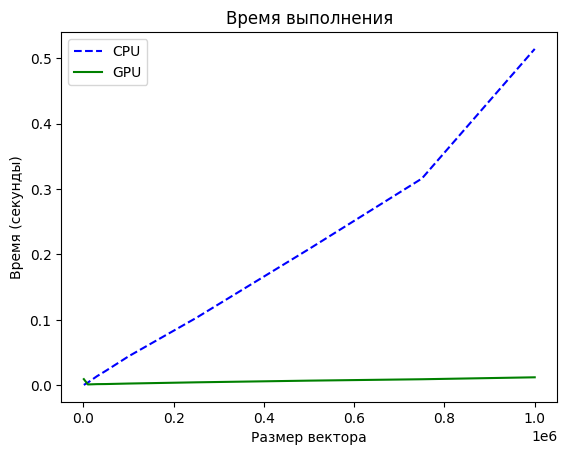

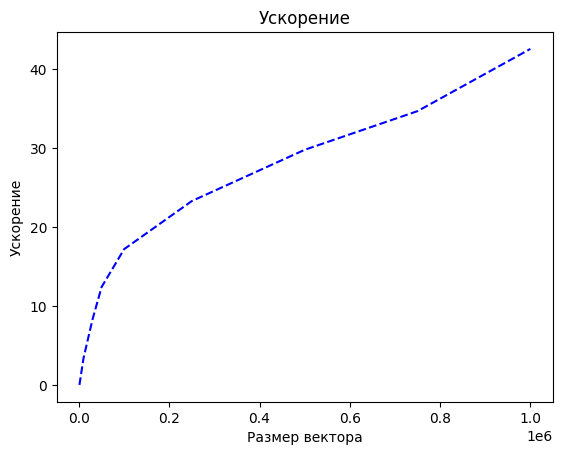

In [2]:
from numba import cuda
import numpy as np
import math
import time
import matplotlib.pyplot as plt

# Функция генерации случайного вектора заданной размерности
def generate_random_vector(dimension):
    return np.random.randint(low=0, high=10, size=dimension)

# Функция сложения элементов вектора на CPU
def cpu_vector_sum(X, Y):
    if len(X) != len(Y):
        raise Exception('Размерности векторов не совпадают')
    result = np.zeros(len(X))
    for i in range(len(X)):
        result[i] = X[i] + Y[i]
    return result

# Константа для настройки количества потоков на блок
THREADS_PER_BLOCK = 256

# Ядро CUDA для сложения элементов вектора
@cuda.jit
def vector_sum(a, b, c):
    tid = cuda.grid(1)
    size = len(c)
    if tid < size:
        c[tid] = a[tid] + b[tid]

# Вспомогательная функция для вызова ядра CUDA
def gpu_vector_sum(X, Y):
    result_host = np.zeros(len(X))

    # Передача данных на устройство (GPU)
    X_device = cuda.to_device(X)
    Y_device = cuda.to_device(Y)
    result_device = cuda.to_device(result_host)

    # Запуск ядра CUDA
    threads_per_block = THREADS_PER_BLOCK
    blocks_per_grid = math.ceil(len(X) / threads_per_block)
    vector_sum[blocks_per_grid, threads_per_block](X_device, Y_device, result_device)

    # Передача данных с устройства на хост (CPU)
    result_host = result_device.copy_to_host()

    return result_host

if __name__ == "__main__":
    sizes = [1000, 10000, 30000, 50000, 100000, 250000, 500000, 750000, 1000000]
    time_cpu = []
    time_gpu = []
    sums_cpu = []
    sums_gpu = []

    for k in sizes:
        cpu_time_sum = 0
        gpu_time_sum = 0
        sum_cpu = 0
        sum_gpu = 0

        for i in range(10):
            X = generate_random_vector(k)
            Y = generate_random_vector(k)

            # Измерение времени выполнения на CPU
            start_time = time.time()
            result_cpu = cpu_vector_sum(X, Y)
            end_time = time.time()
            cpu_time_sum += end_time - start_time

            # Измерение времени выполнения на GPU
            start_time = time.time()
            result_gpu = gpu_vector_sum(X, Y)
            end_time = time.time()
            gpu_time_sum += end_time - start_time

            # Проверка корректности сложения
            if not np.array_equal(result_gpu, result_cpu):
                print("Ошибка: результаты не совпадают!")

            # Суммирование результатов
            sum_cpu += np.sum(result_cpu)
            sum_gpu += np.sum(result_gpu)

        # Среднее время выполнения и средние суммы для текущего размера вектора
        time_cpu.append(cpu_time_sum / 10)
        time_gpu.append(gpu_time_sum / 10)
        sums_cpu.append(sum_cpu / 10)
        sums_gpu.append(sum_gpu / 10)

    print("Результаты")
    print("Время выполнения на CPU: ", time_cpu)
    print("Время выполнения на GPU: ", time_gpu)
    print("Суммы элементов векторов на CPU: ", sums_cpu)
    print("Суммы элементов векторов на GPU: ", sums_gpu)

    # Построение графиков времени выполнения
    plt.title('Время выполнения')
    plt.xlabel('Размер вектора')
    plt.ylabel('Время (секунды)')
    plt.plot(sizes, time_cpu, 'b--', sizes, time_gpu, 'g')
    plt.legend(['CPU', 'GPU'], loc='best')
    plt.show()

    # Очистка графика
    plt.cla()

    # Построение графиков ускорения
    plt.title('Ускорение')
    plt.xlabel('Размер вектора')
    plt.ylabel('Ускорение')
    acceleration = [cpu / gpu for cpu, gpu in zip(time_cpu, time_gpu)]
    plt.plot(sizes, acceleration, 'b--')
    plt.show()